# Loading data

In [2]:
!pip install torch
!pip install tensorflow
!pip install optuna
!pip install keras
!pip install scikeras

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

import torch
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

unemploy = pd.read_csv('UnemploymentRate_InSample.csv')
real_data = pd.read_csv('UnemploymentRate_OutofSample.csv')

# Remove rows with the year 1978
unemploy = unemploy[~unemploy['Date'].str.contains('1978')].reset_index(drop=True)

print(unemploy.info)
print(real_data.info)

<bound method DataFrame.info of           Date  Unemployment Rate
0    1/01/1979             6.0792
1    1/02/1979             5.8594
2    1/03/1979             5.4105
3    1/04/1979             5.2920
4    1/05/1979             5.1199
..         ...                ...
463  1/08/2017             5.5378
464  1/09/2017             5.4050
465  1/10/2017             5.0701
466  1/11/2017             5.0808
467  1/12/2017             5.6025

[468 rows x 2 columns]>
<bound method DataFrame.info of          Date  Unemployment Rate
0   1/01/2018             5.8963
1   1/02/2018             5.8718
2   1/03/2018             5.7359
3   1/04/2018             5.5100
4   1/05/2018             5.2119
5   1/06/2018             5.3308
6   1/07/2018             5.3139
7   1/08/2018             5.2478
8   1/09/2018             4.8260
9   1/10/2018             4.7945
10  1/11/2018             4.8663
11  1/12/2018             4.8782
12  1/01/2019             5.3426
13  1/02/2019             5.2840
14  1/03

# Data Pre-Processing

In [3]:
# Check for missing values in the in_sample_data dataset
missing_values = unemploy.isnull().sum()

# Checking for duplicates in the in_sample_data dataset
duplicates = unemploy.duplicated().sum()
missing_values, duplicates

(Date                 0
 Unemployment Rate    0
 dtype: int64,
 0)

In [4]:
# Checking for missing values in the out_of_sample_data dataset
missing_values_out = real_data.isnull().sum()

# Checking for duplicates in the out_of_sample_data dataset
duplicates_out = real_data.duplicated().sum()
missing_values_out, duplicates_out

(Date                 0
 Unemployment Rate    0
 dtype: int64,
 0)

In [5]:
# Check data types
data_types_in = unemploy.dtypes
data_types_out = real_data.dtypes
data_types_in,  data_types_out

(Date                  object
 Unemployment Rate    float64
 dtype: object,
 Date                  object
 Unemployment Rate    float64
 dtype: object)

In [6]:
# Convert the "Date" column to datetime format
unemploy['Date'] = pd.to_datetime(unemploy['Date'], format='%d/%m/%Y')
unemploy.set_index('Date', inplace=True)

real_data['Date'] = pd.to_datetime(real_data['Date'], format='%d/%m/%Y')
real_data.set_index('Date', inplace=True)

In [7]:
# Checking for outliers using the IQR method
Q1 = unemploy['Unemployment Rate'].quantile(0.25)
Q3 = unemploy['Unemployment Rate'].quantile(0.75)
IQR = Q3 - Q1

# Calculation for outliers
outliers = unemploy[(unemploy['Unemployment Rate'] < (Q1 - 1.5 * IQR)) | (unemploy['Unemployment Rate'] > (Q3 + 1.5 * IQR))]

outliers

,Unemployment Rate
Date,
1993-01-01,12.5376
1993-02-01,12.6958


## Exploratory Data Analysis

In [8]:
# Generating the statistical summary
stats_summary_rounded = unemploy['Unemployment Rate'].describe().round(4)
stats_summary_rounded

count    468.0000
mean       6.7817
std        1.9833
min        3.4992
25%        5.3125
50%        6.1866
75%        8.0900
max       12.6958
Name: Unemployment Rate, dtype: float64

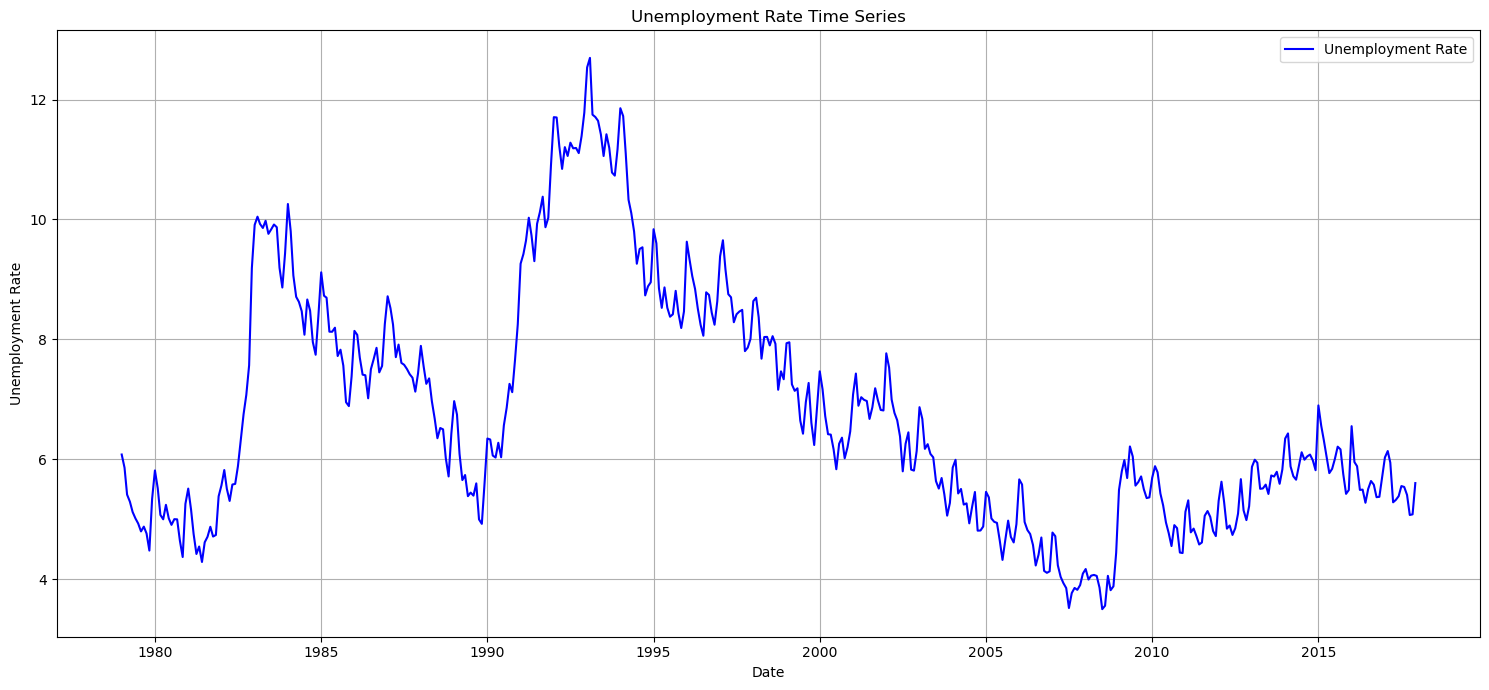

In [9]:
# Plotting the time series
plt.figure(figsize=(15, 7))
plt.plot(unemploy.index, unemploy['Unemployment Rate'], label='Unemployment Rate', color='blue')
plt.title('Unemployment Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

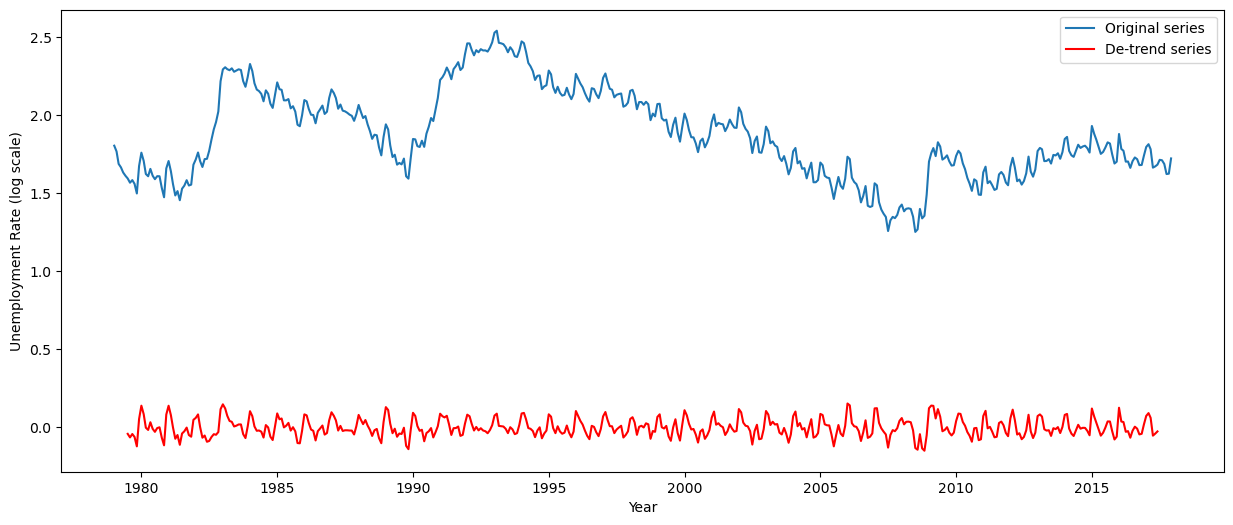

In [10]:
# Apply log transformation to all observations
unemploy_log = np.log(unemploy['Unemployment Rate'])

# Apply CMA-M with M=12 to initially estimate the trend
# Shift the new series to equalize (symmetrize) the number of missing values on both sides
Trend_init = unemploy_log.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

# Subtract the initial trend from the original series to obtaibed the de-trend series
unemploy_res = unemploy_log - Trend_init

# Plot the de-trended and original series
plt.figure(figsize = (15,6))
plt.plot(unemploy_log.index,unemploy_log,label="Original series")
plt.plot(unemploy_log.index,unemploy_res,'r-',label="De-trend series")
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (log scale)')
plt.legend()
plt.show()

In [11]:
# Replace missing values in the unemploy_res by zeros
unemploy_res_zero = np.nan_to_num(unemploy_res)

# Calculate the number of years based on the size of the unemploy_res_zero array
num_years = unemploy_res_zero.shape[0] // 12

# Reshape the de-trended series to a table.
# A column contains data in a particular month of 39 years.
# For example, column 1 contains Unemployed Rate in January of 39 years.
monthly_S = np.reshape(unemploy_res_zero, (num_years, 12))

# Calculate column averages (Average Unemployed Rate in 12 months of 39 years)
monthly_avg = np.mean(monthly_S[1:38,:], axis=0)

In [12]:
# Normalize the seasonal index
seasonal_idx = monthly_avg.mean()
seasonal_idx_normalized = monthly_avg - seasonal_idx
print(seasonal_idx_normalized.mean())

2.023844055306275e-18


In [13]:
# Replicate the normalized seasonal index array 39 times
# to obtain the final estimation of the seasonal component
seasonal = np.tile(seasonal_idx_normalized, num_years)

# Subtract the seasonal average from the original data
# to obtain the seasonal adjusted data
seasonally_adjusted = unemploy_log - seasonal

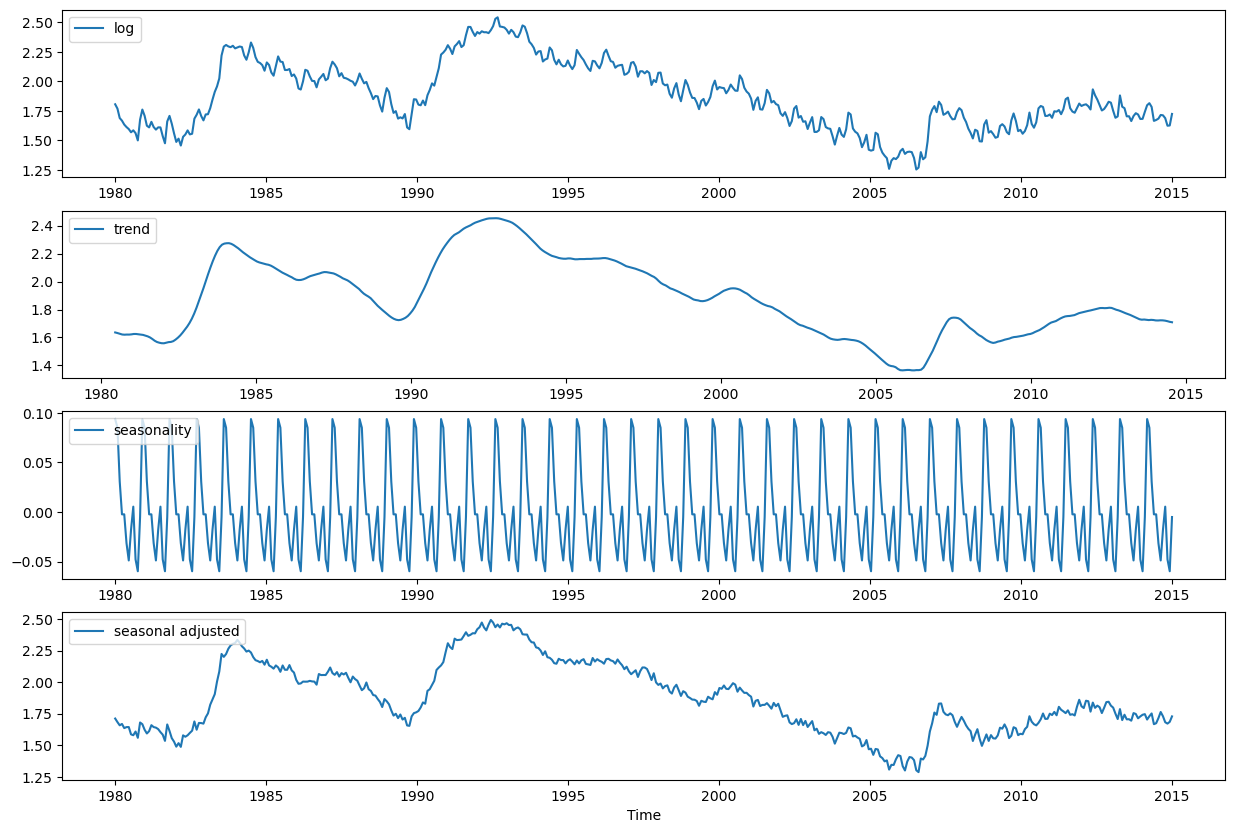

In [14]:
# Plot the seasonally adjusted data:
fig, ax = plt.subplots(4, 1,figsize=(15,10))
years = np.linspace(1980, 2015, len(unemploy_log))

ax[0].plot(years, unemploy_log)
ax[1].plot(years, Trend_init)
ax[2].plot(years, seasonal)
ax[3].plot(years, seasonally_adjusted)
ax[0].legend(['log'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)
plt.xlabel('Time')
plt.show()

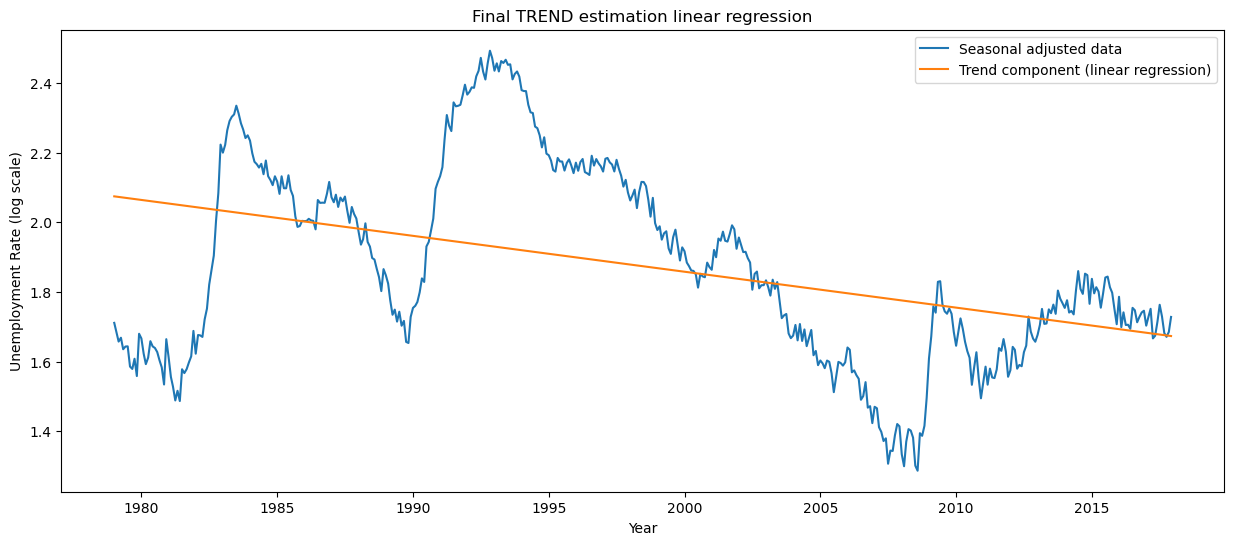

In [15]:
# Prepare training data
X = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted), 1))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted.values

# Create a LinearRegression object
lm = LinearRegression()

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

# Obtain estimation for the trend using the trained linear model
X_fitting = np.reshape(np.arange(1,len(seasonally_adjusted)+1), (len(seasonally_adjusted),1))
trend_linear = lm.predict(X_fitting)

# Now plot the seasonally adjusted data and the corresponding regression line
plt.figure(figsize=(15,6))
plt.plot(unemploy.index,seasonally_adjusted)
plt.plot(unemploy.index,trend_linear)
plt.title('Final TREND estimation linear regression')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (log scale)')
plt.legend(['Seasonal adjusted data','Trend component (linear regression)'])
plt.show()

In [16]:
# Forecast the trend component in Jan 1961
Trend_forecast = lm.predict(np.array([[len(unemploy)+1]]))

# Forecast the seasonal component in Jan 1961
Seasonal_forecast = seasonal_idx_normalized[0]

# Get the sum of the trend and seasonal forecasts
Y_forecast = Trend_forecast + Seasonal_forecast
Y_forecast

array([1.76621376])

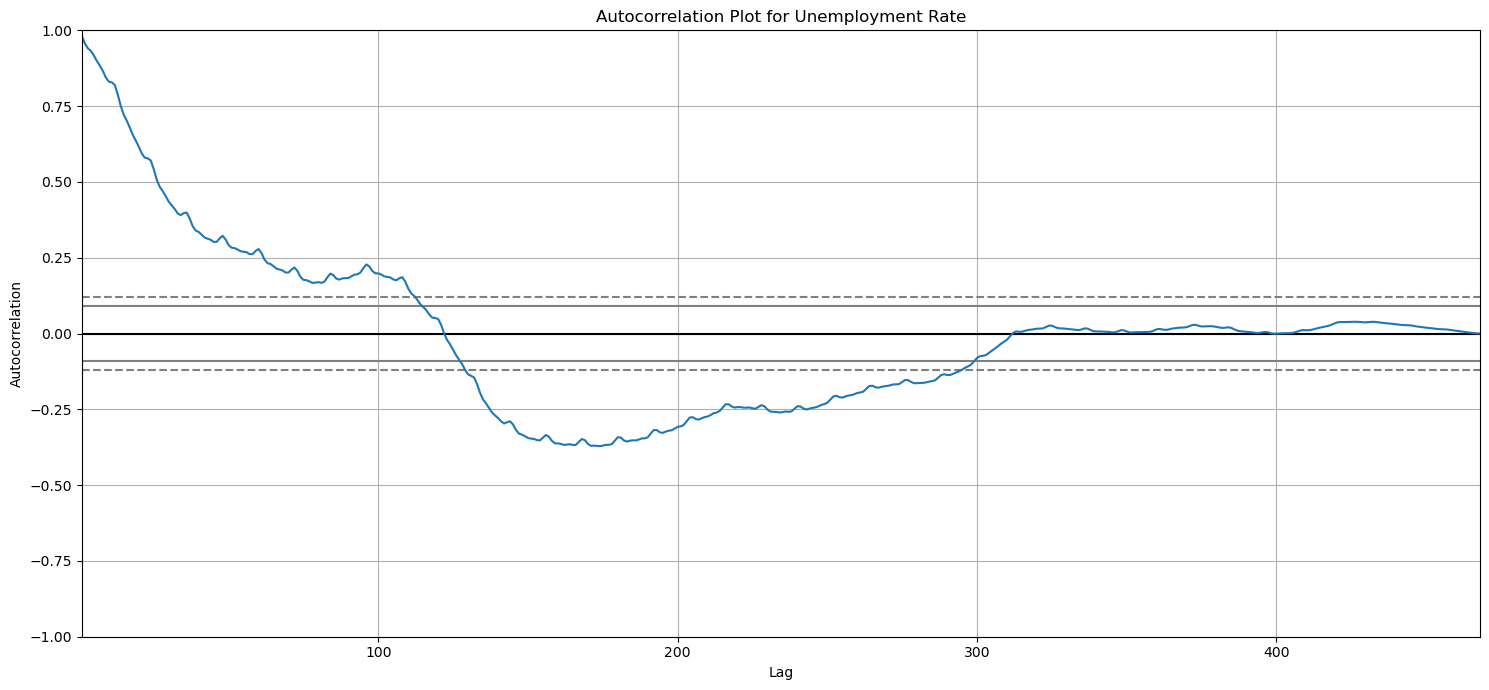

In [17]:
# Autocorrelation plot
plt.figure(figsize=(15, 7))
pd.plotting.autocorrelation_plot(unemploy['Unemployment Rate'])
plt.title('Autocorrelation Plot for Unemployment Rate')
plt.tight_layout()
plt.show()

# Methodology and forecasting results

## ARIMA Model




#### ACF & PACF of the dataset

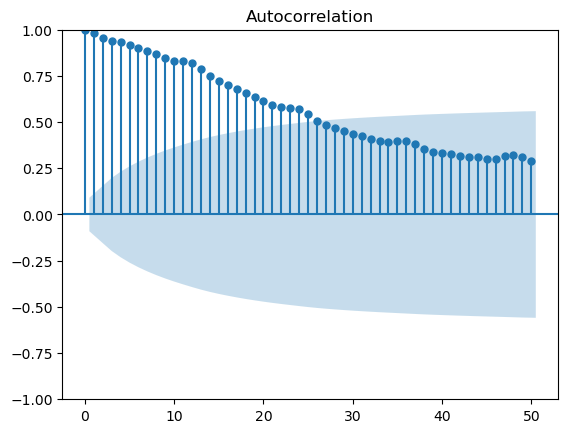

In [18]:
smt.graphics.tsa.plot_acf(unemploy, lags=50, alpha = 0.05)
plt.show()

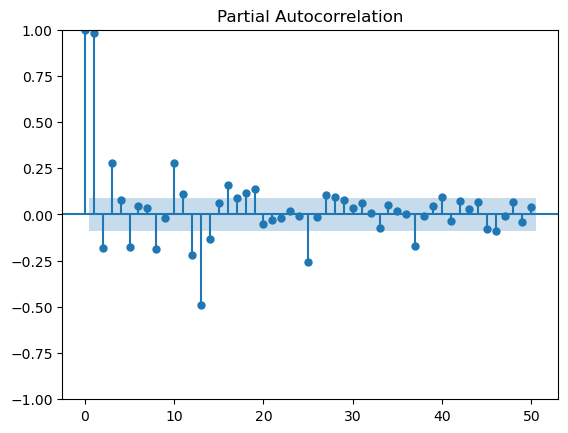

In [19]:
smt.graphics.tsa.plot_pacf(unemploy, lags=50, alpha = 0.05)
plt.show()

#### Test stationarity

Results of Dickey-Fuller Test:
Test Statistic                  -1.796153
pvalue                           0.382373
#Lags Used                      18.000000
Number of Observations Used    449.000000
Critical Value (1%)             -3.444998
Critical Value (5%)             -2.867999
Critical Value (10%)            -2.570210
dtype: float64


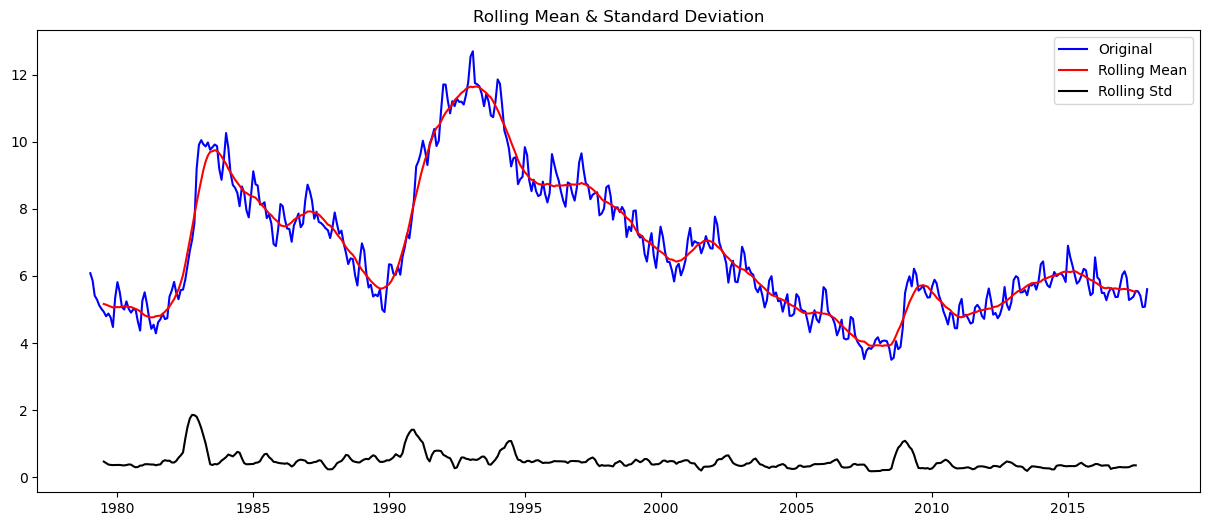

In [20]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')

    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def plot_curve(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12,center=True).mean()
    rolstd = timeseries.rolling(12,center=True).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Call test_stationarity() function to perform Dickey-Fuller test for the original series
test_stationarity(unemploy)

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(unemploy)

For the data to be considered stationary, the ADF statistic should be less than the critical values (more negative). In this case, the ADF statistic is -1.7962, which is higher than all the critical values. Furthermore, the p-value is 0.3824, which is greater than the common significance levels (e.g., 0.05). Thus, we fail to reject the null hypothesis and conclude that the data is not stationary.

#### Difference the unstationary
Turn the un-stationary data into stationary and plot the differentiated data

In [21]:
# Calculate difference series
unemploy_diff = pd.Series.diff(unemploy)

# Check the first entry in diff_data
unemploy_diff.iloc[0]

0   NaN
Name: 1979-01-01 00:00:00, dtype: float64

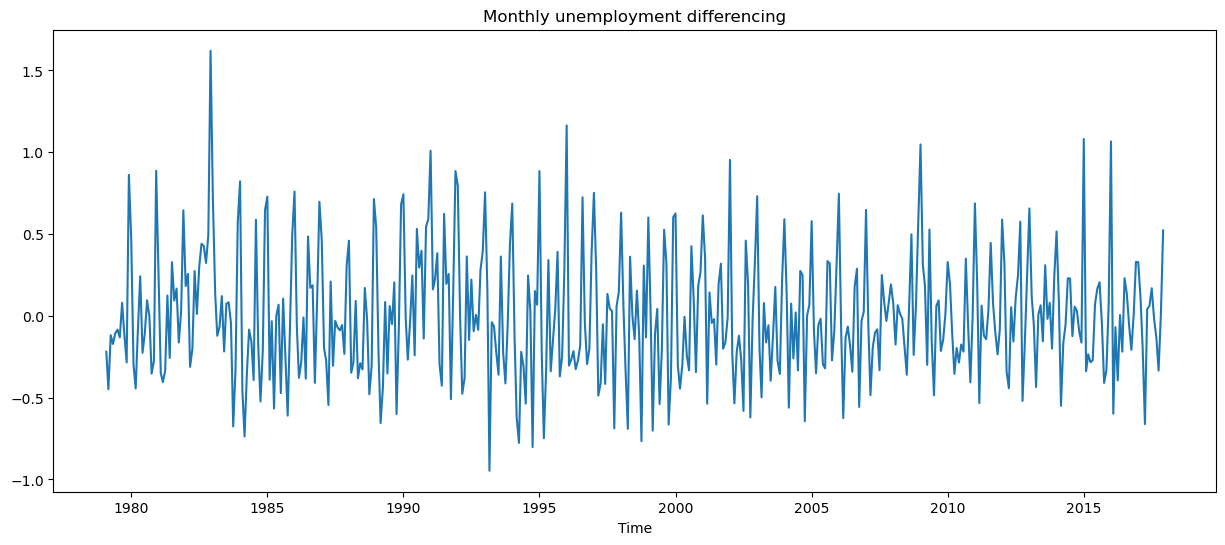

In [22]:
# Discard the nan value
unemploy_diff = unemploy_diff.dropna()

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(unemploy_diff)
plt.xlabel('Time')
plt.title('Monthly unemployment differencing')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.914874e+00
pvalue                         2.586977e-07
#Lags Used                     1.700000e+01
Number of Observations Used    4.490000e+02
Critical Value (1%)           -3.444998e+00
Critical Value (5%)           -2.867999e+00
Critical Value (10%)          -2.570210e+00
dtype: float64


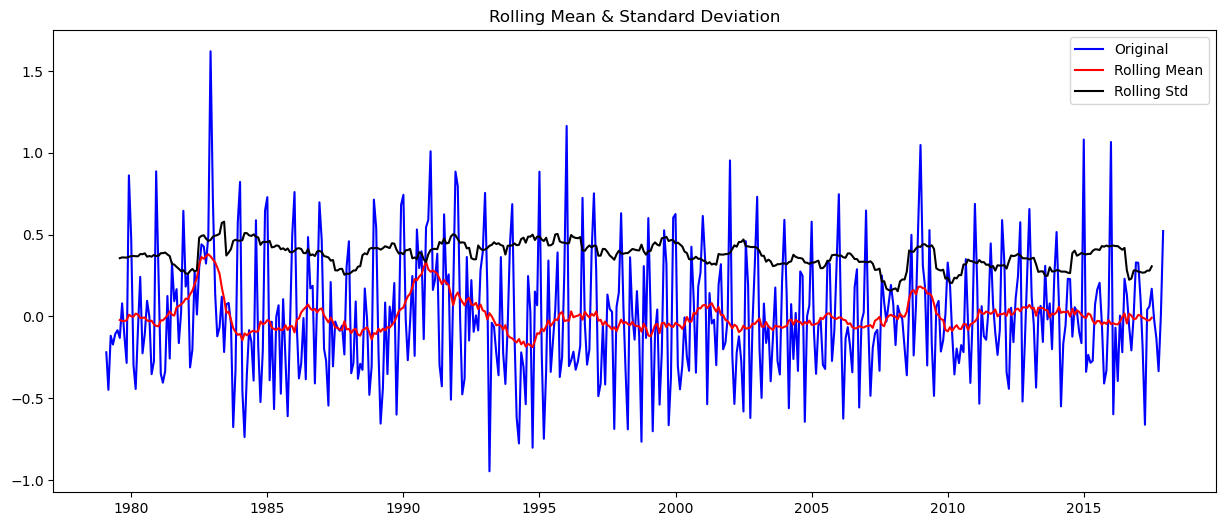

In [23]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')

    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def plot_curve(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12,center=True).mean()
    rolstd = timeseries.rolling(12,center=True).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Call test_stationarity() function to perform Dickey-Fuller test for the original series
test_stationarity(unemploy_diff)

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(unemploy_diff)

After differencing the data, the ADF statistic is -5.9149, which is less than (more negative than) all the critical values. Additionally, the p-value is very close to zero, indicating strong evidence against the null hypothesis. Thus, we can conclude that the differenced data is stationary.


#### ACF of the differentiated data

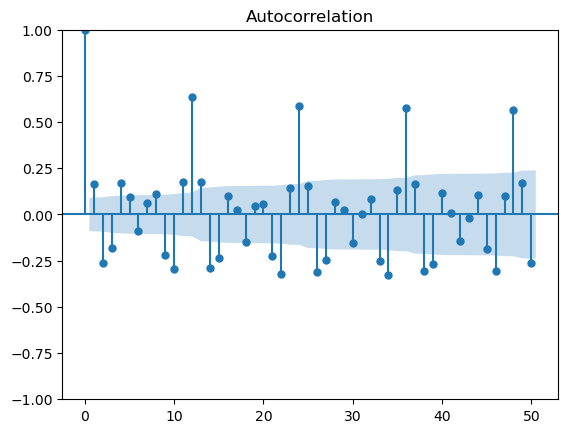

In [24]:
smt.graphics.tsa.plot_acf(unemploy_diff, lags=50, alpha = 0.05)
plt.show()

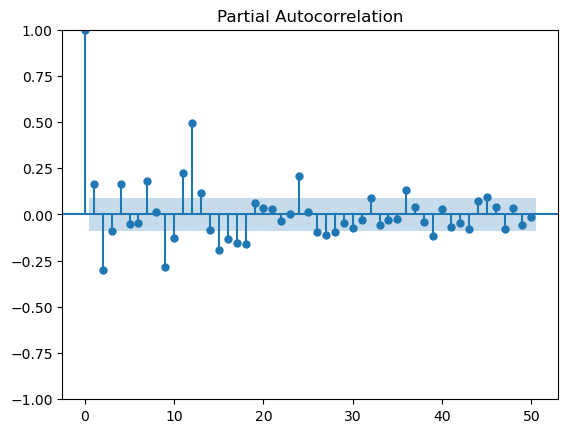

In [25]:
smt.graphics.tsa.plot_pacf(unemploy_diff, lags=50, alpha = 0.05)
plt.show()

The ACF plot shows a clear seasonal pattern. So, here we will transform the data again using seasonal differencing.

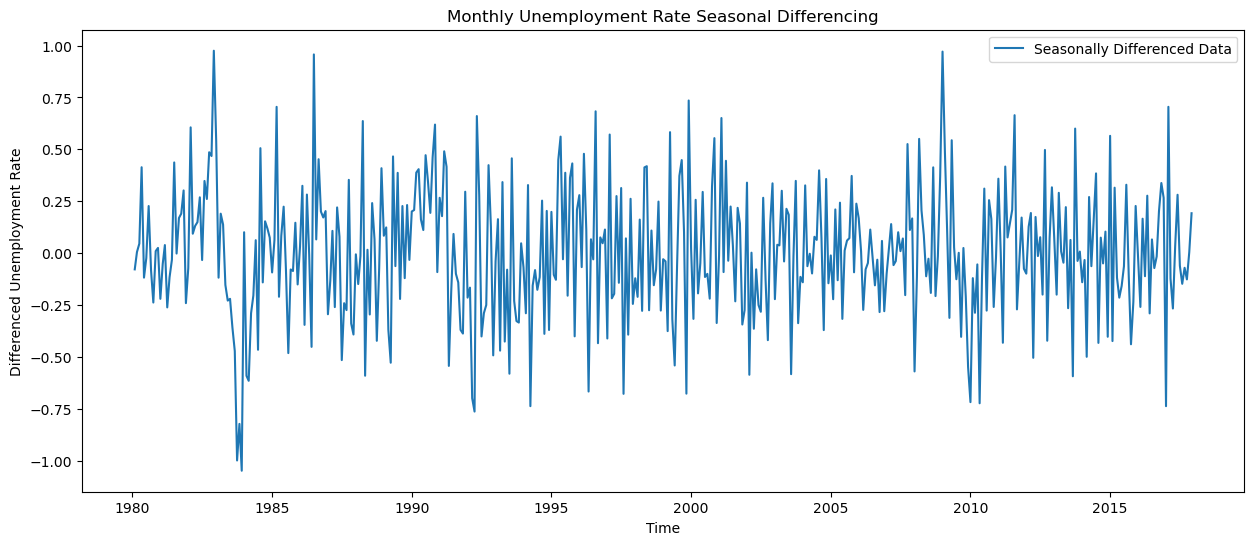

In [26]:
# Perform seasonal differencing with a lag of 12 periods
seasonal_diff = unemploy_diff.diff(12)

# Discard the NaN values that result from seasonal differencing
seasonal_diff = seasonal_diff.dropna()

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(seasonal_diff, label='Seasonally Differenced Data')
plt.xlabel('Time')
plt.ylabel('Differenced Unemployment Rate')
plt.title('Monthly Unemployment Rate Seasonal Differencing')
plt.legend()
plt.show()

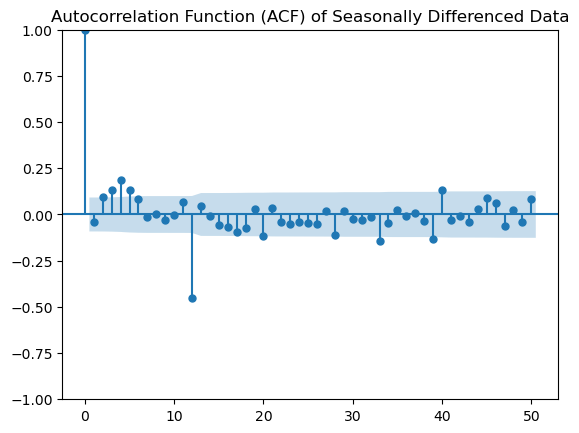

<Figure size 1500x600 with 0 Axes>

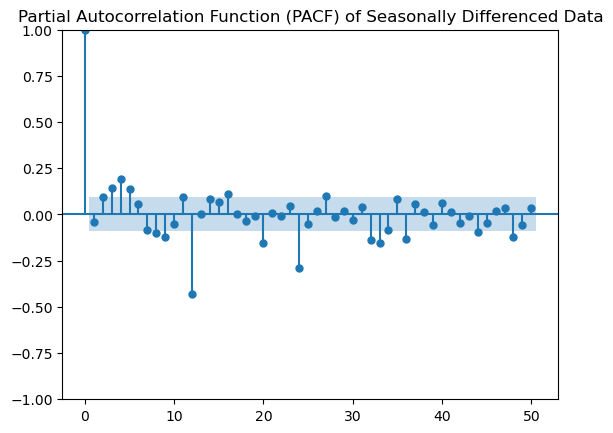

<Figure size 1500x600 with 0 Axes>

In [27]:
# Plot the ACF of the seasoanl first order differenced data
smt.graphics.tsa.plot_acf(seasonal_diff, lags=50, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) of Seasonally Differenced Data')
plt.figure(figsize=(15, 6))
plt.show()

# Plot the PACF of the seasoanl first order differenced data
smt.graphics.tsa.plot_pacf(seasonal_diff, lags=50, alpha = 0.05)
plt.title('Partial Autocorrelation Function (PACF) of Seasonally Differenced Data')
plt.figure(figsize=(15, 6))
plt.show()

#### MA(p) Model

In [28]:
def fit_ma_model(order):
    model = ARIMA(unemploy, order=(0,1,order))
    model_fit = model.fit()
    return model_fit.aic

# Define a range for q values (since we are fitting MA models)
q_values = range(1, 11)

# Initialize variables to store the best order and its respective AIC
best_aic = float('inf')  
best_order_aic = None

# Fit MA models for each q value and update the best order based on AIC
for q in q_values:
    aic = fit_ma_model(q)
    if aic < best_aic:
        best_aic = aic
        best_order_aic = q

# Output the best order based on AIC
best_model_aic = {
    'order': best_order_aic,
    'AIC': round(best_aic, 4)
}

best_model_aic

{'order': 8, 'AIC': 298.3652}

In [29]:
model = ARIMA(unemploy, order=(0,1,8))
model_fit_ma8 = model.fit()
predictions_ma8 = model_fit_ma8.forecast(steps=24)

actual_values = real_data.iloc[:24].values.squeeze()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predictions_ma8))
print(f"Root Mean Squared Error for ARIMA(0,1,8) predictions: {rmse:.4f}")

Root Mean Squared Error for ARIMA(0,1,8) predictions: 0.4275


#### AR(p) Model

In [30]:
def fit_ar_model(order):
    model = ARIMA(unemploy, order=(order, 1, 0))
    model_fit = model.fit()
    return model_fit.aic

# Define a range for p values (since we are fitting AR models)
p_values = range(1, 11)

# Initialize variables to store the best order and its respective AIC
best_aic = float('inf')  # start with a very large value
best_order_aic = None

# Fit AR models for each p value and update the best order based on AIC
for p in p_values:
    aic = fit_ar_model(p)
    if aic < best_aic:
        best_aic = aic
        best_order_aic = p

# Output the best order based on AIC
best_model_aic = {
    'order': best_order_aic,
    'AIC': round(best_aic, 4)
}

best_model_aic

{'order': 10, 'AIC': 299.1693}

In [31]:
# Fit AR(10) model to the differenced data
model = ARIMA(unemploy, order=(10,1,0))
model_fit_ar10 = model.fit()

# Display the summary of the AR(10) model
model_fit_ar10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Unemployment Rate   No. Observations:                  468
Model:                ARIMA(10, 1, 0)   Log Likelihood                -138.585
Date:                Thu, 02 Nov 2023   AIC                            299.169
Time:                        22:57:35   BIC                            344.779
Sample:                    01-01-1979   HQIC                           317.118
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1838      0.044      4.188      0.000       0.098       0.270
ar.L2         -0.1642      0.047     -3.478      0.001      -0.257      -0.072
ar.L3         -0.1764      0.047     -3.758      0.000      -0.268      -0.084
ar.L4          0.1725      0.045      3.796      0.000       0.083       0.262
ar.L5          0.0609      0.052      1.161      0.246      -0.042       0.164
ar.L6         -0.1016      0.047     -2.140      0.032      -0.195      -0.009
ar.L7          0.0874      0.049      1.767      0.077      -0.010       0.184
ar.L8          0.0504      0.051      0.984      0.325      -0.050       0.151
ar.L9         -0.2568      0.052     -4.977      0.000      -0.358      -0.156
ar.L10        -0.1263      0.048     -2.657      0.008      -0.220      -0.033
sigma2         0.1056      0.006     16.561      0.000       0.093       0.118
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                18.34
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Forecast 24 steps ahead
predictions_ar10 = model_fit_ar10.forecast(steps=24)

actual_values = real_data.iloc[:24].values.squeeze()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predictions_ar10))
print(f"Root Mean Squared Error for ARIMA(10,1,0) predictions: {rmse:.4f}")

Root Mean Squared Error for ARIMA(10,1,0) predictions: 0.5679


#### ARIMA Model

In [33]:
# Define the range for p, d, q
p_range = range(0, 6)
d_range = range(0, 2)
q_range = range(0, 6)

# Initialize variables to store best parameters and associated AIC
best_aic = np.inf
best_order_aic = None

# Loop over p, d, q values
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Fit the ARIMA model
                model = ARIMA(unemploy, order=(p, d, q))
                model_fit = model.fit()

                # Check if current model's AIC is lower than the best found so far
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order_aic = (p, d, q)
            except:
                # Some combinations might not converge or produce errors, so we continue to the next iteration
                continue

best_order_aic, best_aic

((5, 1, 2), 255.36731127257218)

In [34]:
model_arima=ARIMA(unemploy,order=(5, 1, 2))
model_arima_fit=model_arima.fit()
model_arima_fit.summary()

model_arima_forecast = model_arima_fit.forecast(steps=24)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_values, model_arima_forecast))
print(f"Root Mean Squared Error for ARIMA(5,1,2) predictions: {rmse:.4f}")

Root Mean Squared Error for ARIMA(5,1,2) predictions: 0.4746


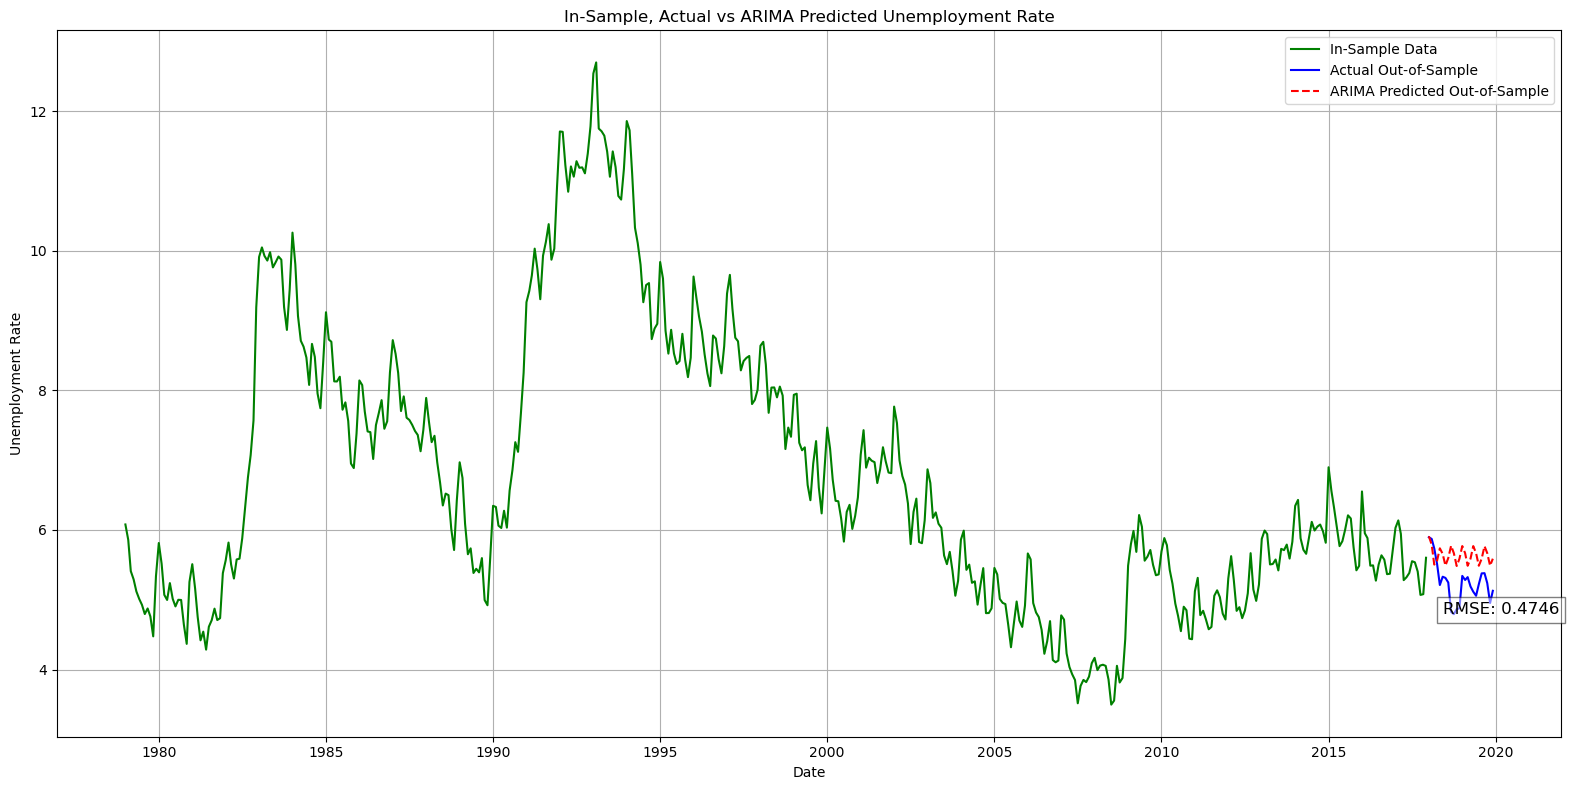

0.47460178336279035

In [35]:
# Fit the ARIMA(5, 1, 2) model to the unemploy data
arima_model = ARIMA(unemploy['Unemployment Rate'], order=(5, 1, 2))
arima_result = arima_model.fit()

# Forecast 24 steps ahead
forecast_arima = arima_result.forecast(steps=24)
predicted_mean_arima = forecast_arima

# Calculate RMSE for ARIMA model
rmse_arima = np.sqrt(mean_squared_error(real_data['Unemployment Rate'], predicted_mean_arima))

# Plotting the results
plt.figure(figsize=(16, 8))

# In-sample data
plt.plot(unemploy.index, unemploy['Unemployment Rate'], label='In-Sample Data', color='green')

# Actual out-of-sample values
plt.plot(real_data.index, real_data['Unemployment Rate'], label='Actual Out-of-Sample', color='blue')

# ARIMA predicted out-of-sample values
plt.plot(real_data.index, predicted_mean_arima, label='ARIMA Predicted Out-of-Sample', color='red', linestyle='--')

# Title, labels, and RMSE text
plt.title('In-Sample, Actual vs ARIMA Predicted Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.text(real_data.index[5], real_data['Unemployment Rate'].min(), f'RMSE: {rmse_arima:.4f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

rmse_arima

#### Seasonal ARMIA Model

In [ ]:
# Define the p, d, q parameters to take any value from 0 to 5
p = q = range(0, 6)

# Define the seasonal P, D, Q parameters to take any value from 0 to 1
P = Q = range(0, 2)
d = D = 1
s = 12  # Seasonal period

# Create a list with all the different combinations of parameters
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = list(itertools.product(P, [1], Q, [s]))

best_rmse = float('inf')
best_cfg = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # The actual fitting of the SARIMAX model happens here
            model = SARIMAX(unemploy, order=param, seasonal_order=seasonal_param)
            results = model.fit(disp=0)

            # Here you would obtain your out-of-sample forecast
            forecast = results.get_forecast(steps=24)
            forecast_values = forecast.predicted_mean

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

            # Check if this RMSE is the best one so far
            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = (param, seasonal_param)
                best_model = results

        except Exception as e:
            continue  

print(f"Best SARIMA model: {best_cfg} with RMSE: {best_rmse:.4f}")

In [ ]:
actual_values = real_data.iloc[:24].values.squeeze()

# Fit SARIMA model using optimal parameters
optimal_sarima_model = SARIMAX(unemploy,
                               order=(5, 1, 1),
                               seasonal_order=(0, 1, 0, 12))
optimal_sarima_fit = optimal_sarima_model.fit(disp=0)

# Display model summary
print(optimal_sarima_fit.summary())


# Forecast out-of-sample data (next 24 data points)
forecast_sarima = optimal_sarima_fit.forecast(steps=24)

# Calculate RMSE between the forecast and the actual out-of-sample data
rmse = np.sqrt(mean_squared_error(actual_values, forecast_sarima))

print(f"RMSE: {rmse:.4f}")

In [ ]:
# Fit the SARIMA(5, 1, 1), (0, 1, 0, 12) model to the unemploy data
sarima_511_model = SARIMAX(unemploy['Unemployment Rate'], order=(5, 1, 1), seasonal_order=(0, 1, 0, 12))
sarima_511_result = sarima_511_model.fit(disp=False)

# Forecast 24 steps ahead
forecast_511 = sarima_511_result.get_forecast(steps=24)
predicted_mean_511 = forecast_511.predicted_mean

# Calculate RMSE
rmse_511 = np.sqrt(mean_squared_error(real_data['Unemployment Rate'], predicted_mean_511))

# Plotting the actual vs predicted values with corrected date processing and RMSE
plt.figure(figsize=(16, 8))

# Plotting the in-sample data
plt.plot(unemploy.index, unemploy['Unemployment Rate'], label='In-Sample Data', color='green')

# Plotting the actual out-of-sample values
plt.plot(real_data.index, real_data['Unemployment Rate'], label='Actual Out-of-Sample', color='blue')

# Plotting the predicted out-of-sample values
plt.plot(real_data.index, predicted_mean_511, label='Predicted Out-of-Sample', color='red', linestyle='--')

# Adding title, labels, and RMSE text
plt.title('In-Sample, Actual vs Predicted Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.text(real_data.index[5], real_data['Unemployment Rate'].min(), f'RMSE: {rmse_511:.4f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

## Holt-Winters method

#### Seasonal

In [ ]:
y = unemploy['Unemployment Rate']

# Find l0, b0, and s0 using linear regression
def linearOptimization(X, m):

    # Prepare training data (X,y)
    x = np.linspace(1, len(X), len(X))
    x = np.reshape(x, (len(x), 1))
    y = np.reshape(X, (len(X), 1))

    # Train a linear regression
    lm = LinearRegression().fit(x, y)
    l0 = lm.intercept_
    b0 = lm.coef_[0]

    # Use trained linear regression model to get y^t
    s0 = np.mean(np.reshape(y + 0. - lm.predict(x),(int(len(X)/m),m)), axis=0)

    # return l0, b, and s
    return l0, b0, s0

In [ ]:
def addSeasonal(Y, m, alpha = None, beta = None, gamma = None, \
                l0 = None, b0 = None, s = None):
    # Get time series length
    T = len(Y)

    # Pre-allocating arrays storing level,trend,seasonality
    l = np.zeros(T)           # To store l0
    b = np.zeros(T)           # To store b0
    s = np.zeros(T+m)         # To store s0
    y_smoothed = np.zeros(T)  # To store smoothed value at time t

    # If parameters are not defined, use their default values
    if (alpha == None or beta == None or gamma == None):
        alpha, beta, gamma = 0.1, 0.1, 0.1

    # If initial values for level, trend and seasonality have not initialized
    # Then call the linearOptimization() function to compute these values
    if (l0 == None or b0 == None or s == None):
        l0,b0,s0 = linearOptimization(Y,m)

    # Add initial values to the pre-allocated arrays for level, trend and seasonality
    s[:m] = s0
    l[0] = alpha*(Y[0]-s[0]) + (1-alpha)*(l0 + b0)   # Compute level at time t=1
    b[0] = beta*(l[0]-l0) + (1-beta)*b0              # Compute trend at time t=1
    s[m] = gamma*(Y[0]-l0-b0) + (1-gamma)*s[0]       # Compute seasonality at time t=1
    y_smoothed[0] = l[0]+b[0]+s[1]

    # Smoothing the time series. We start from time t=2
    for t in np.arange(1,T):

        # update the l,b,s and y
        l[t] = alpha*(Y[t]-s[t]) + (1-alpha) * (l[t-1] + b[t-1])
        b[t] = beta*(l[t]-l[t-1]) + (1-beta) * b[t-1]
        s[m+t] = gamma*(Y[t]-l[t-1]-b[t-1]) + (1-gamma)*s[t]

        # Get smoothed value
        y_smoothed[t] = (l[t]+ b[t] + s[t+1])

    # Calculate the SSE of in-sample forecast
    SSE = np.sum(np.power(np.array(Y[1:]) - np.array(y_smoothed[:-1]),2))

    return y_smoothed, l, b, s[m:], SSE

In [ ]:
# Seasonal period
M = 12

# Call the addSeasonal() function to implement the Holt-Winters smoothing method
y_smoothed, l, b, s, SSE = addSeasonal(Y = y.tolist(), m = M)

# Store components in a Data Frame to plot.
# These components are considered as latent states of underlying data generating process
states = pd.DataFrame(np.c_[l, b, s], columns=['Level','Trend','Seasonal'])

In [ ]:
# Plot the original and forecasted series
plt.figure(figsize=(15,6))
plt.plot(y.index,y,label='Original data')
plt.plot(y.index[1:],y_smoothed[:-1], '-r', label='Holt-Winters additive forecast')
plt.title('Annually Unemployment Rate')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.legend(loc=2)
plt.show()

# Plot level, trend and seasonality
fig, ax = plt.subplots(3, 1, figsize=(15,8))
ax[0].plot(y.index,states['Level'])
ax[1].plot(y.index,states['Trend'])
ax[2].plot(y.index,states['Seasonal'])
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.show()

In [ ]:
# 1. holt_winters_forecast function (already defined above)
def holt_winters_forecast(Y, l, b, s, m, alpha, beta, gamma, forecast_steps=24):
    T = len(Y)
    y_forecast = [0] * (T + forecast_steps)
    y_forecast[:T] = Y  # Initial values

    for t in range(T, T + forecast_steps):
        y_forecast[t] = (l[-1] + (t - T + 1) * b[-1] + s[t - m])
        l.append(alpha * (y_forecast[t] - s[t - m]) + (1 - alpha) * (l[-1] + b[-1]))
        b.append(beta * (l[-1] - l[-2]) + (1 - beta) * b[-1])
        s.append(gamma * (y_forecast[t] - l[-1] - b[-1]) + (1 - gamma) * s[t - m])

    return y_forecast[-forecast_steps:]

# 2. Trim the unemploy_series_filtered Series to ensure its length is a multiple of 12
Y_series = y.tolist()
trim_length_series = len(Y_series) - (len(Y_series) % 12)
Y_trimmed_series = Y_series[:trim_length_series]

# 3. Use the addSeasonal function to get the smoothed values and components for the trimmed series
y_smoothed_series, l_series, b_series, s_series, SSE_series = addSeasonal(Y_trimmed_series, m=12)

# 4. Generate a 24-step forecast using the adjusted function
forecasted_values_series = holt_winters_forecast(Y_trimmed_series, l_series.tolist(), b_series.tolist(), s_series.tolist(), m=12, alpha=0.1, beta=0.1, gamma=0.1)

# 5. Compute the RMSE for the forecast against the real_data
RMSE_seasonal_adjusted_series = mean_squared_error(real_data['Unemployment Rate'], forecasted_values_series, squared=False)

print('RMSE of seasonal Holt-Winters: {:.4f}'.format(RMSE_seasonal_adjusted_series))

#### Additive and Multiplicative


In [ ]:
fit_add = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_mul = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing

In [ ]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
print(results)

In [ ]:
# Obtain fitted values from the fittedvalues attribute
smooth_add = fit_add.fittedvalues
smooth_mul = fit_mul.fittedvalues

# Plot all together
plt.figure(figsize=(15,6))
plt.plot(y[1:], 'b-', label = 'Original data')
plt.plot(smooth_add, 'r-.',label = 'Holt-Winters additivie')
plt.plot(smooth_mul, 'g--', label = 'Holt-Winters multiplicative')
plt.xlabel("Year")
plt.ylabel("Unemployment Rate")
plt.title("Holt-Winters' methods")
plt.legend()
plt.show()

In [ ]:
# Forecast 24 more data points
y_forecast_add = fit_add.forecast(24)
y_forecast_mul = fit_mul.forecast(24)

# And plot all together
plt.figure(figsize=(16,5))
plt.plot(y_forecast_add, label = 'Holt-Winters additive')
plt.plot(y_forecast_mul, label = 'Holt-Winters multiplicative')
plt.xlabel("Year")
plt.ylabel("Unemployment rate")
plt.title("Forecasts from Holt-Winters'methods")
plt.legend()
plt.show()

In [ ]:
# Compare the forecasting outcomes of additive and multiplicative
# For additive model
df_add = pd.DataFrame(np.c_[y, fit_add.level, fit_add.trend, fit_add.season, fit_add.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'], index=y.index)

# Assuming fit_add.forecast(24) returns a Series
forecast_add = fit_add.forecast(24).rename(r'$\hat{y}_t$').to_frame()

# Concatenating along the correct axis (axis=0 by default for appending rows)
df_add = pd.concat([df_add, forecast_add])

# For multiplicative model
df_mul = pd.DataFrame(np.c_[y, fit_mul.level, fit_mul.trend, fit_mul.season, fit_mul.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'], index=y.index)

# Assuming fit_mul.forecast(24) returns a Series
forecast_mul = fit_mul.forecast(24).rename(r'$\hat{y}_t$').to_frame()

# Concatenating along the correct axis (axis=0 by default for appending rows)
df_mul = pd.concat([df_mul, forecast_mul])

In [ ]:
# Ploting the level, trend and season for fit_add and fit_mul
# Define 2 states variable for conveinence
states_add = pd.DataFrame(np.c_[fit_add.level, fit_add.trend, fit_add.season], \
                       columns=['level','trend','seasonal'], \
                       index=y.index)
states_mul = pd.DataFrame(np.c_[fit_mul.level, fit_mul.trend, fit_mul.season], \
                       columns=['level','trend','seasonal'], \
                       index=y.index)

# Define subplots windows
fig, ax = plt.subplots(3, 2, figsize=(15,8))
ax[0,0].plot(states_add['level'])
ax[1,0].plot(states_add['trend'])
ax[2,0].plot(states_add['seasonal'])
ax[0,1].plot(states_mul['level'])
ax[1,1].plot(states_mul['trend'])
ax[2,1].plot(states_mul['seasonal'])
ax[0,0].legend(['Additive - level'], loc=2)
ax[1,0].legend(['Additive - trend'], loc=2)
ax[2,0].legend(['Additive - seasonal'], loc=2)
ax[0,1].legend(['Multiplicative - level'], loc=2)
ax[1,1].legend(['Multiplicative - trend'], loc=2)
ax[2,1].legend(['Multiplicative - seasonal'], loc=2)

plt.show()

In [ ]:
# The calculation of forecast errors
forecast_errors_additive = real_data['Unemployment Rate'] - y_forecast_add.values
forecast_errors_multiplicative = real_data['Unemployment Rate'] - y_forecast_mul.values

# Recalculating RMSE for each model
RMSE_additive_adjusted = np.sqrt(np.mean(forecast_errors_additive**2))
RMSE_multiplicative_adjusted = np.sqrt(np.mean(forecast_errors_multiplicative**2))
print("RMSE of additive Holt-Winters: {:.4f}".format(RMSE_additive_adjusted))
print("RMSE of multiplicative Holt-Winters: {:.4f}".format(RMSE_multiplicative_adjusted))

## Simple Exponential Smoothing (SES)

In [ ]:
# Set a small value for alpha
alpha = 0.1

# Initialize the smooth series by copying the visitors series(pre-allocation)
# By doing this, we imply that l0 is set to be the first value of the visitors series
lt_manual = y.copy().astype(float)

# Define l0 and compute l1
l0 = y[0]
lt_manual[0] = alpha*y[0] + (1-alpha)*l0

# Start from l2
for t in range(1,len(y)):
    # Calculate smoothed value at time t using equations in (2)
    lt_manual[t] = alpha*y[t] +(1-alpha)*lt_manual[t-1]

# Print lt_manual
lt_manual

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y, label = "Original data")
plt.plot(lt_manual, label = "Manual smoothed curve (SES), alpha = 0.1")
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

In [ ]:
lt_pandas1 = y.ewm(alpha=0.05, adjust=False).mean()
lt_pandas2 = y.ewm(alpha=0.1, adjust=False).mean()
lt_pandas3 = y.ewm(alpha=0.3, adjust=False).mean()
lt_pandas4 = y.ewm(alpha=0.7, adjust=False).mean()

plt.figure(figsize=(16,8))
plt.plot(y, label='Original data')
plt.plot(lt_pandas1, label = "Alpha = 0.05")
plt.plot(lt_pandas2, label = "Alpha = 0.1")
plt.plot(lt_pandas3, label = "Alpha = 0.3")
plt.plot(lt_pandas4, label = "Alpha = 0.7")
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title("SES smoothing with various values of Alpha")
plt.legend()
plt.show()

In [ ]:
def sse(x, y):
    return np.sum(np.power(x-y,2))

# Initialize an empty list to store SSE for each value of alpha
sse_twenty_four = []

# Define an array of values for alpha
alphas = np.arange(0.01,1,0.01)

# Loop through alphas
for i in alphas:
    smoothed = y.ewm(alpha = i, adjust=False).mean()
    sse_twenty_four.append(sse(smoothed[:-24], y.values[24:]))

plt.figure()
plt.plot(sse_twenty_four)
plt.title("SSE for 24-step smoothing")
plt.ylabel("SSE")
plt.xlabel("Alpha")
plt.xticks(np.linspace(0, 100, 10), ["{0:1.1f}".format(x) for x in np.linspace(0,1,10)])
plt.show()

In [ ]:
optimal_alpha_24 = alphas[np.argmin(sse_twenty_four)]
print("Optimal Alpha for 24-step forecast: {}".format(optimal_alpha_24))

In [ ]:
# Apply exponential smoothing using alpha = 0.99
alpha = 0.99
smoothed = y.ewm(alpha=alpha, adjust=False).mean()
forecast_24 = [smoothed.iloc[-1]] * 24

# Extract the first 24 values from the out-of-sample data for comparison
y_out_of_sample = real_data['Unemployment Rate'][:24]

# Compute RMSE
rmse = mean_squared_error(y_out_of_sample, forecast_24, squared=False)
print("RMSE of simple expoential smoothing: {:.4f}".format(rmse))

## TCES

In [ ]:
ts_unemploy=unemploy['Unemployment Rate']
ts_real=real_data['Unemployment Rate']
T_unemploy=len(ts_unemploy)
T_real=len(ts_real)
ts = pd.concat([ts_unemploy, ts_real], axis=0)
ts_unemploy.index.freq = 'MS' # set frequency

In [ ]:
# Define a range of alpha and beta values to search
alpha_range = np.arange(0.01,1,0.01)
beta_range = np.arange(0.01,1,0.01)

#initial the best_rmse,best_alpha and best_beta
best_rmse = float('inf')
best_alpha = None
best_beta = None

# Perform the grid search
for alpha in alpha_range:
    for beta in beta_range:
        model = Holt(ts_unemploy)
        fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)

        forecasts = fitted_model.forecast(steps=T_real)
        rmse = mean_squared_error(ts_real.values, forecasts, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_beta = beta

#print the result
print(f"Best Alpha: {best_alpha}")
print(f"Best Beta: {best_beta}")
print(f"Best RMSE: {best_rmse}")

In [ ]:
# Set a small value for alpha and beta
alpha = 0.08
beta = 0.06

#Fit the Holt's linear method model to your training data:

model = Holt(ts_unemploy)
fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)

# Generate forecasts for the validation period using the fitted TCES model:
y_forecast_TCES = fitted_model.forecast(steps=T_real)

In [ ]:
rmse_tces = np.sqrt(mean_squared_error(ts_real, y_forecast_TCES))
print("RMSE of TCES : {:.4f}".format(rmse_tces))

## Simple Moving Average

In [ ]:
ts_forecast_df = pd.DataFrame(ts_real)

for i in range(3,16):
    ts_rolling = ts.rolling(i).mean()
    ts_one_step_MA = ts_rolling[-T_real-1:-1].to_numpy()
    ts_forecast_df[f'Pred_one_step_MA{i}'] = ts_one_step_MA
    rmse_MA = rmse = np.sqrt(mean_squared_error(ts_real, ts_forecast_df[f'Pred_one_step_MA{i}']))
    result2 = pd.DataFrame({'RMSE': [rmse_MA]}, index=[f'MA{i}']).round(4)
    print(result2)


## Neutral network

### Standard neutral network

In [ ]:
# Convert data from Dataframe to array
data = pd.concat((unemploy, real_data), axis=0)
data_not_scaled = data.values.astype('float')
time_window = 12
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = unemploy.size
test_size = real_data.size
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])
data_scaled = fitted_transformer.transform(data_not_scaled)

# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0]) # Access the accuracy
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0]) # Training NN
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

model = Sequential()
model.add(Dense(10, input_dim = time_window, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(Xtrain, Ytrain, epochs=3000, batch_size=5, shuffle=True, verbose=1)
# In-sample and out of sample forecast
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)

Predict_in = allPredictPlot[:train_size]
Predict_out = allPredictPlot[-test_size:]

plt.figure(figsize=(15,6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(data.index[-(train_size+test_size):-test_size],Predict_in, label='In-sample forecasts')
plt.plot(data.index[-test_size:],Predict_out, label='Out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

# Checking training and test score
trainScore_not_scaled = np.sqrt(mean_squared_error(unemploy, Predict_in))
testScore_not_scaled = np.sqrt(mean_squared_error(real_data, Predict_out))

print('Training Data RMSE on original scale: {0:.4f}'.format(trainScore_not_scaled))
print('Test Data RMSE original scale: {0:.4f}'.format(testScore_not_scaled))

### Recurrent Neutral Network (RNN)

In [ ]:
# Long-Short Term Memory (LSTM)
import random as python_random
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# For time series and LSTM layer we need to reshape into 3D array
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window,1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window,1))

model = Sequential()
model.add(LSTM(units=8,input_shape = (time_window,1)))
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

In [ ]:
model.fit(Xtrain, Ytrain,
          batch_size = 5,
          epochs = 300,
          validation_split = 0.1,
          shuffle = False,
          verbose = 1)

# Predicting
allPredict = model.predict(np.reshape(Xall, (Xall.shape[0],time_window,1)))

#Transforming to original scale
allPredict_original_scale = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data_scaled)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict_original_scale

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction')
plt.legend()
plt.show()

# Checking training and test score
trainScore = np.sqrt(mean_squared_error(unemploy, allPredict_original_scale[:train_size,0]))
testScore = np.sqrt(mean_squared_error(real_data, allPredict_original_scale[-test_size:,0]))

print('Training Data RMSE: {0:.4f}'.format(trainScore))
print('Test Data RMSE: {0:.4f}'.format(testScore))

In [ ]:
# Dynamic forecast with LSTM
dynamic_prediction = np.copy(data_scaled[:len(data_scaled) - test_size])

for i in range(len(data_scaled) - test_size, len(data_scaled)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

# Plot
test_index = np.arange(len(data_scaled) - test_size, len(data_scaled), 1)

plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled[:len(data_scaled) - test_size]), label='Training Data')
plt.plot(test_index, scaler.inverse_transform(data_scaled[-test_size:]), label='Testing Data')
plt.plot(test_index, dynamic_prediction_original_scale[-test_size:], label='Out of Sample Prediction')
plt.legend(loc = "upper left")
plt.show()

# Compute RMSE score on test data
testScore = np.sqrt(mean_squared_error(real_data, dynamic_prediction_original_scale[-test_size:]))
print('Dynamic Forecast RMSE: {0:.4f}'.format(testScore))

reference:
https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
https://www.tensorflow.org/api_docs/python/tf/random/set_seed

### Best model

In [ ]:
num_layers = [1, 2, 3]
num_neurons = [10, 20, 30]

best_model = None
best_test_score = float('inf')

# Iterate through different combinations of layers and neurons
for num_layer in num_layers:
    for num_neuron in num_neurons:
        model = Sequential()
        model.add(Dense(num_neuron, input_dim=time_window, activation='relu'))
        for _ in range(num_layer - 1):
            model.add(Dense(num_neuron, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Train the model
        model.fit(Xtrain, Ytrain, epochs=3000, validation_split=0.1,
                  batch_size=5, shuffle=False, verbose=0)

        # Make predictions and calculate RMSE
        allPredict = model.predict(Xall)
        allPredictPlot = scaler.inverse_transform(allPredict)
        Predict_out = allPredictPlot[-test_size:]
        test_score = np.sqrt(mean_squared_error(real_data, Predict_out))

        # compare RMSE
        print(f'Layers: {num_layer}, Neurons: {num_neuron}')
        print(f'Test Data RMSE original scale: {test_score:.4f}')

        if test_score < best_test_score:
            best_model = model
            best_test_score = test_score

# best model
best_model.summary()
!pip install optuna
import optuna

def objective(trial):
    # Define search spaces for hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    batch_size = trial.suggest_int("batch_size", 5, 30)
    num_epochs = trial.suggest_int("num_epochs", 50, 500)
    best_model.fit(Xtrain, Ytrain, epochs=num_epochs, batch_size=batch_size, verbose=0)

    # Make predictions on the test set
    allPredict = best_model.predict(Xall)
    allPredictPlot = scaler.inverse_transform(allPredict)
    Predict_out = allPredictPlot[-test_size:]

    # Calculate the RMSE on the test set
    test_score = np.sqrt(mean_squared_error(real_data, Predict_out))

    return test_score

# Create an Optuna study and start optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
# Unpack hyperparameters from the best_params dictionary
learning_rate = best_params["learning_rate"]
batch_size = best_params["batch_size"]
num_epochs = best_params["num_epochs"]
optimizer = Adam(learning_rate=learning_rate)

# Fit the model using the specified batch size and number of epochs
best_model.fit(Xtrain, Ytrain, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

# Make predictions using the retrained best model
allPredict_best = best_model.predict(Xall)
allPredictPlot_best = scaler.inverse_transform(allPredict_best)
Predict_out = allPredictPlot_best[-test_size:]

# Plot
plt.figure(figsize=(15,6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(data.index[:train_size], allPredictPlot_best[:train_size], label='In-sample forecasts')
plt.plot(data.index[-test_size:], allPredictPlot_best[-test_size:], label='Out-of-sample forecasts')
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.legend()
plt.show()

# Checking training and test score
trainScore = np.sqrt(mean_squared_error(unemploy, allPredictPlot[:train_size]))
testScore = np.sqrt(mean_squared_error(real_data, allPredictPlot[-test_size:]))

print('Training Data RMSE on original scale: {0:.4f}'.format(trainScore))
print('Test Data RMSE original scale: {0:.4f}'.format(testScore))